In [1]:
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
import matplotlib.patheffects as PathEffects

from mapie.regression import MapieRegressor
from mapie.metrics import regression_coverage_score, regression_mean_width_score
from mapie.regression import MapieRegressor
from mapie.subsample import Subsample

from sklearn.preprocessing import  MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [2]:
conformal_metrics_vanilla = {
 "cutoff": [0.0, 0.005404300522059202, 0.033684518188238144, 0.05, 0.1, 0.2, 0.3, 0.3890679180622101, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95],
"coverage_naive": [0.7387387387387387, 0.7063318777292577, 0.6786885245901639, 0.6776429809358753, 0.6897880539499036, 0.6666666666666666, 0.6122448979591837, 0.6524590163934426, 0.6732673267326733, 0.6692307692307692, 0.6291666666666667, 0.5866666666666667, 0.5720930232558139, 0.599009900990099, 0.5906432748538012, 0.6186440677966102],
"coverage_cv_plus": [0.8124488124488124, 0.8220524017467249, 0.8081967213114755, 0.8318890814558059, 0.7880539499036608, 0.7952380952380952, 0.7784256559766763, 0.8622950819672132, 0.8250825082508251, 0.8384615384615385, 0.8166666666666667, 0.8177777777777778, 0.8325581395348837, 0.8811881188118812, 0.8713450292397661, 0.8305084745762712],
"coverage_jackknife_plus_ab": [0.7371007371007371, 0.7030567685589519, 0.6983606557377049, 0.7036395147313691, 0.6994219653179191, 0.65, 0.597667638483965, 0.6786885245901639, 0.6666666666666666, 0.6923076923076923, 0.6375, 0.6, 0.5953488372093023, 0.6386138613861386, 0.6198830409356725, 0.6101694915254238],
"interval_width_naive": [0.33615486145019524, 0.3936747789382934, 0.466556578874588, 0.49313491582870483, 0.487522155046463, 0.5079672932624817, 0.49069738388061523, 0.44034600257873535, 0.4177010893821716, 0.263324589729309, 0.1493734073638917, 0.15726344108581536, 0.14645690917968746, 0.10872319698333734, 0.11693801879882804, 0.08713016510009772],
"interval_width_cv_plus": [0.4668159315342589, 0.586368582336256, 0.7235728639830667, 0.7403800183014566, 0.7302039602808726, 0.7549307892043143, 0.7676098270888058, 0.7277213052921607, 0.7387384294998208, 0.5471554418948408, 0.4016485076894363, 0.35569797782037, 0.34765150171449016, 0.2791582903140547, 0.25024804303956305, 0.2040898787899543],
"interval_width_jackknife_plus_ab": [0.36039082529103555, 0.46384172792555495, 0.556070822257092, 0.5413734147596377, 0.539451971366545, 0.5724188050525243, 0.5658157869805662, 0.5073035879693213, 0.5271816855408832, 0.4149356539053507, 0.3260407831630946, 0.28178233859655377, 0.275307510405132, 0.2507502335634401, 0.24274082546734074, 0.18510055958909732]
}

conformal_metrics_full = {
 "cutoff": [0.0, 0.02019340731203556, 0.05, 0.08336329460144043, 0.1, 0.2, 0.3, 0.3942202627658844, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95],
"coverage_naive": [0.7452907452907452, 0.7417582417582418, 0.7130177514792899, 0.6967213114754098, 0.6843003412969283, 0.7184684684684685, 0.7402234636871509, 0.7275862068965517, 0.7047244094488189, 0.6533333333333333, 0.6313131313131313, 0.6538461538461539, 0.6692913385826772, 0.6019417475728155, 0.5777777777777777],
"coverage_cv_plus": [0.8026208026208026, 0.8274725274725274, 0.8239644970414202, 0.8114754098360656, 0.8020477815699659, 0.8175675675675675, 0.8100558659217877, 0.8172413793103448, 0.8267716535433071, 0.8088888888888889, 0.8232323232323232, 0.9038461538461539, 0.84251968503937, 0.8252427184466019, 0.8],
"coverage_jackknife_plus_ab": [0.7510237510237511, 0.743956043956044, 0.7366863905325444, 0.7081967213114754, 0.6945392491467577, 0.7117117117117117, 0.6927374301675978, 0.696551724137931, 0.6968503937007874, 0.6755555555555556, 0.6363636363636364, 0.6346153846153846, 0.6456692913385826, 0.7184466019417476, 0.6888888888888889],
"interval_width_naive": [0.322261244058609, 0.40983694791793823, 0.48056086897850037, 0.4802219867706299, 0.46945762634277344, 0.5350031852722168, 0.5142185688018799, 0.3193846702575684, 0.2116791915893554, 0.15133106946945185, 0.09953787326812737, 0.06926748275756832, 0.06730165958404541, 0.06365835905075065, 0.041161084175109774],
"interval_width_cv_plus": [0.4185412854836212, 0.5398344419704197, 0.6410543321871843, 0.6636718530707275, 0.6900948589100142, 0.6846545961404823, 0.6774929595878088, 0.5892208908485441, 0.4004148539921313, 0.3097164634916517, 0.20581690796547467, 0.15928808751396645, 0.13721544881974615, 0.12202947386983529, 0.08167739729748831],
"interval_width_jackknife_plus_ab": [0.36390308438205504, 0.44925150174469797, 0.5222394097007471, 0.5368396887135725, 0.5508325172156908, 0.5615734695823149, 0.5558552061604769, 0.4378218054687386, 0.3351707858856022, 0.2610127360180157, 0.18176604478649605, 0.1578344907225396, 0.1364895012324654, 0.1573999745364928, 0.12151573378974767]
}

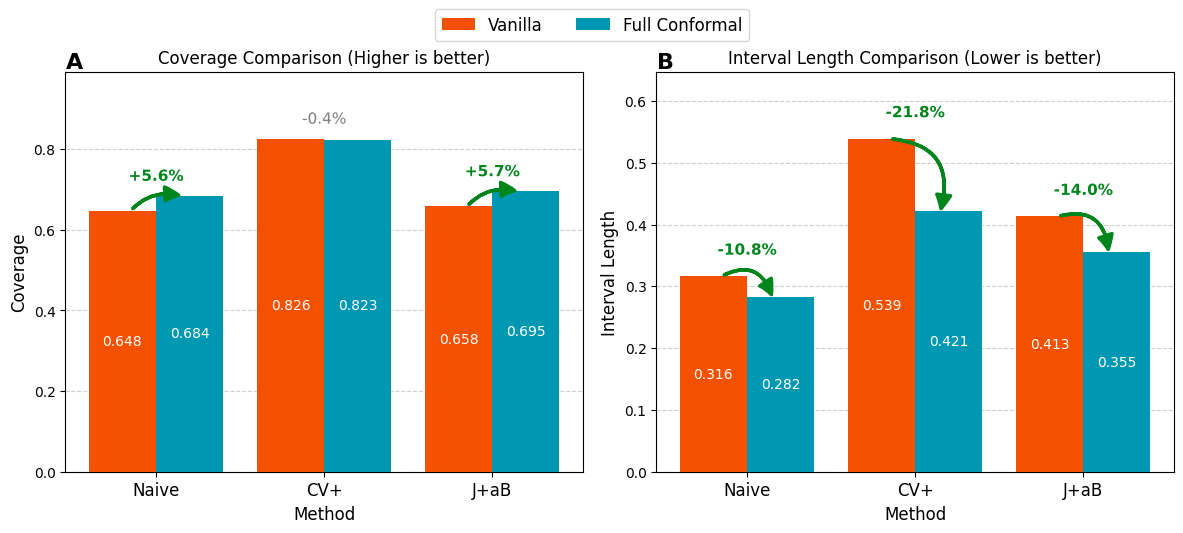

In [3]:
# Calculate averages for all metrics
def calculate_average_metrics(metrics_dict):
    avg_metrics = {
        'coverage_naive': np.mean(metrics_dict['coverage_naive']),
        'coverage_cv_plus': np.mean(metrics_dict['coverage_cv_plus']),
        'coverage_jackknife_plus_ab': np.mean(metrics_dict['coverage_jackknife_plus_ab']),
        'interval_width_naive': np.mean(metrics_dict['interval_width_naive']),
        'interval_width_cv_plus': np.mean(metrics_dict['interval_width_cv_plus']),
        'interval_width_jackknife_plus_ab': np.mean(metrics_dict['interval_width_jackknife_plus_ab'])
    }
    return avg_metrics

# Calculate the averages
vanilla_avg = calculate_average_metrics(conformal_metrics_vanilla)
full_avg = calculate_average_metrics(conformal_metrics_full)

# Calculate percentage differences
diff_coverage_naive = (full_avg['coverage_naive'] - vanilla_avg['coverage_naive']) / vanilla_avg['coverage_naive'] * 100
diff_coverage_cv_plus = (full_avg['coverage_cv_plus'] - vanilla_avg['coverage_cv_plus']) / vanilla_avg['coverage_cv_plus'] * 100
diff_coverage_jackknife = (full_avg['coverage_jackknife_plus_ab'] - vanilla_avg['coverage_jackknife_plus_ab']) / vanilla_avg['coverage_jackknife_plus_ab'] * 100

diff_interval_naive = (vanilla_avg['interval_width_naive'] - full_avg['interval_width_naive']) / vanilla_avg['interval_width_naive'] * 100
diff_interval_cv_plus = (vanilla_avg['interval_width_cv_plus'] - full_avg['interval_width_cv_plus']) / vanilla_avg['interval_width_cv_plus'] * 100
diff_interval_jackknife = (vanilla_avg['interval_width_jackknife_plus_ab'] - full_avg['interval_width_jackknife_plus_ab']) / vanilla_avg['interval_width_jackknife_plus_ab'] * 100

# Create the visualization
width = 0.4  # Adjusted bar width
methods = ['Naive', 'CV+', 'J+aB']
x = np.arange(len(methods))

# Set up color scheme
vanilla_color = '#F35000'  # Vibrant orange
conformal_color = '#0097B2'  # Vibrant teal
pos_color = '#00851D'  # Stronger green for better visibility
neg_color = '#D01C1C'  # Stronger red for better visibility

# Create figure with standard proportions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
plt.rcParams.update({'font.size': 12})  # Set base font size

# === COVERAGE COMPARISON (Panel A) ===
vanilla_coverage = [vanilla_avg['coverage_naive'], vanilla_avg['coverage_cv_plus'], vanilla_avg['coverage_jackknife_plus_ab']]
full_coverage = [full_avg['coverage_naive'], full_avg['coverage_cv_plus'], full_avg['coverage_jackknife_plus_ab']]

# Format values to 3 decimal places for consistency
vanilla_coverage_formatted = [f"{val:.3f}" for val in vanilla_coverage]
full_coverage_formatted = [f"{val:.3f}" for val in full_coverage]

bar1 = ax1.bar(x - width/2, vanilla_coverage, width, label='Vanilla', color=vanilla_color, zorder=5)
bar2 = ax1.bar(x + width/2, full_coverage, width, label='Full Conformal', color=conformal_color, zorder=5)

# Function to add centered labels in bars
def add_centered_labels(bars, formatted_values, ax):
    for bar, value in zip(bars, formatted_values):
        height = bar.get_height()
        # Position labels in the middle of the bars
        ax.text(bar.get_x() + bar.get_width()/2., height/2,
                value, ha='center', va='center', fontsize=10, zorder=10,
                color='white')  # White text for contrast

add_centered_labels(bar1, vanilla_coverage_formatted, ax1)
add_centered_labels(bar2, full_coverage_formatted, ax1)

# Set coverage y-axis to start at 0 for accurate visual comparison
ax1.set_ylim(0, max(max(vanilla_coverage), max(full_coverage)) * 1.2)  # Increased padding for labels

ax1.set_xticks(x)
ax1.set_xticklabels(methods, fontsize=12)
ax1.set_xlabel('Method', fontsize=12)
ax1.set_ylabel('Coverage', fontsize=12)
ax1.set_title('Coverage Comparison (Higher is better)', fontsize=12)

# Reduce number of grid lines for less clutter
ax1.grid(axis='y', linestyle='--', alpha=0.6, zorder=1)
ax1.set_axisbelow(True)  # Ensure grid is behind bars

# === INTERVAL WIDTH COMPARISON (Panel B) ===
vanilla_interval = [vanilla_avg['interval_width_naive'], vanilla_avg['interval_width_cv_plus'], vanilla_avg['interval_width_jackknife_plus_ab']]
full_interval = [full_avg['interval_width_naive'], full_avg['interval_width_cv_plus'], full_avg['interval_width_jackknife_plus_ab']]

# Format values to 3 decimal places for consistency
vanilla_interval_formatted = [f"{val:.3f}" for val in vanilla_interval]
full_interval_formatted = [f"{val:.3f}" for val in full_interval]

bar3 = ax2.bar(x - width/2, vanilla_interval, width, color=vanilla_color, zorder=5)
bar4 = ax2.bar(x + width/2, full_interval, width, color=conformal_color, zorder=5)

add_centered_labels(bar3, vanilla_interval_formatted, ax2)
add_centered_labels(bar4, full_interval_formatted, ax2)

# Set interval y-axis to start at 0
ax2.set_ylim(0, max(max(vanilla_interval), max(full_interval)) * 1.2)  # Increased padding for labels

ax2.set_xticks(x)
ax2.set_xticklabels(methods, fontsize=12)
ax2.set_xlabel('Method', fontsize=12)
ax2.set_ylabel('Interval Length', fontsize=12)
ax2.set_title('Interval Length Comparison (Lower is better)', fontsize=12)

# Reduce number of grid lines for less clutter
ax2.grid(axis='y', linestyle='--', alpha=0.6, zorder=1)
ax2.set_axisbelow(True)  # Ensure grid is behind bars

# === ARROWS AND LABELS WITH MORE CURVE ===
arrow_style = "simple,head_width=10,head_length=10"
arrow_linewidth = 2.5

# Add curved arrows
coverage_diffs = [diff_coverage_naive, diff_coverage_cv_plus, diff_coverage_jackknife]
interval_diffs = [diff_interval_naive, diff_interval_cv_plus, diff_interval_jackknife]

for i, (diff_cov, diff_int) in enumerate(zip(coverage_diffs, interval_diffs)):
    # Coverage arrows and annotations
    vanilla_bar_top = vanilla_coverage[i]
    full_bar_top = full_coverage[i]
    arrow_center_x = x[i]
    
    # Use consistent curvature for all arrows (-0.3 rad)
    # For coverage: higher is better
    if diff_cov > 1.0:  # Only show significant improvements (>1%)
        # Draw curved arrow from vanilla to full conformal
        arrow = FancyArrowPatch(
            (arrow_center_x - width/2 + 0.05, vanilla_bar_top), 
            (arrow_center_x + width/2 - 0.05, full_bar_top),
            connectionstyle=f"arc3,rad=-0.3", 
            arrowstyle=arrow_style, 
            color=pos_color, 
            linewidth=arrow_linewidth,
            zorder=10
        )
        ax1.add_patch(arrow)
        
        # Add text with percentage improvement
        text = ax1.text(arrow_center_x, max(vanilla_bar_top, full_bar_top) + 0.03,
                f'+{abs(diff_cov):.1f}%', ha='center', va='bottom', 
                fontsize=11, color=pos_color, fontweight='bold')
        text.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='white')])
    elif diff_cov < -1.0:  # Only show significant decreases (<-1%)
        # Draw curved arrow from vanilla to full conformal
        arrow = FancyArrowPatch(
            (arrow_center_x - width/2 + 0.05, vanilla_bar_top), 
            (arrow_center_x + width/2 - 0.05, full_bar_top),
            connectionstyle=f"arc3,rad=-0.3", 
            arrowstyle=arrow_style, 
            color=neg_color, 
            linewidth=arrow_linewidth,
            zorder=10
        )
        ax1.add_patch(arrow)
        
        # Add text with percentage decrease
        text = ax1.text(arrow_center_x, max(vanilla_bar_top, full_bar_top) + 0.03,
                f'{diff_cov:.1f}%', ha='center', va='bottom', 
                fontsize=11, color=neg_color, fontweight='bold')
        text.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='white')])
    else:
        # For the -0.4% case (essentially equivalent), show a muted label
        text = ax1.text(arrow_center_x, max(vanilla_bar_top, full_bar_top) + 0.03,
                f'{diff_cov:.1f}%', ha='center', va='bottom', 
                fontsize=11, color='#666666', fontweight='normal', alpha=0.8)
        text.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='white')])
    
    # Interval width arrows and annotations - WITH MORE CURVED ARROWS
    vanilla_bar_top_int = vanilla_interval[i]
    full_bar_top_int = full_interval[i]
    
    # For interval: lower is better
    if diff_int > 0:  # Full conformal has shorter interval (better)
        # Draw MORE curved arrow from vanilla to full conformal
        arrow = FancyArrowPatch(
            (arrow_center_x - width/2 + 0.05, vanilla_bar_top_int), 
            (arrow_center_x + width/2 - 0.05, full_bar_top_int),
            connectionstyle=f"arc3,rad=-0.6",  # Much more curved (-0.6 instead of -0.3)
            arrowstyle=arrow_style, 
            color=pos_color, 
            linewidth=arrow_linewidth,
            zorder=10
        )
        ax2.add_patch(arrow)
        
        # Position text ABOVE the bar for better visibility
        # This ensures it's always visible
        text = ax2.text(arrow_center_x, max(vanilla_bar_top_int, full_bar_top_int) + 0.03,
                f'-{abs(diff_int):.1f}%', ha='center', va='bottom', 
                fontsize=11, color=pos_color, fontweight='bold')
        text.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='white')])

# Add legend with standard styling
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, fontsize=12, 
          bbox_to_anchor=(0.5, 0.95), frameon=True)

# Add letters A and B to the subplots
ax1.text(0.035, 1.05, 'A', transform=ax1.transAxes, 
         fontsize=16, fontweight='bold', va='top', ha='right')
ax2.text(0.035, 1.05, 'B', transform=ax2.transAxes, 
         fontsize=16, fontweight='bold', va='top', ha='right')

# Adjust layout
plt.tight_layout(rect=[0, 0.05, 1, 0.9])

# plt.savefig('fixed_labels_curved_arrows.png', dpi=400, bbox_inches='tight')
plt.show()

Best Arrow (Current version)

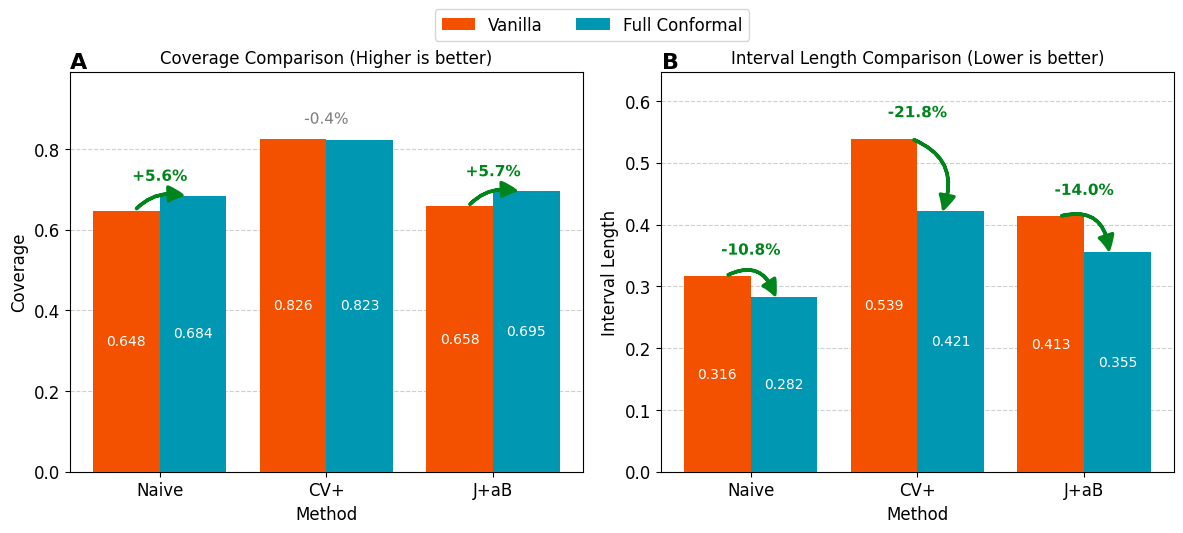

In [4]:
def calculate_average_metrics(metrics_dict):
    avg_metrics = {
        'coverage_naive': np.mean(metrics_dict['coverage_naive']),
        'coverage_cv_plus': np.mean(metrics_dict['coverage_cv_plus']),
        'coverage_jackknife_plus_ab': np.mean(metrics_dict['coverage_jackknife_plus_ab']),
        'interval_width_naive': np.mean(metrics_dict['interval_width_naive']),
        'interval_width_cv_plus': np.mean(metrics_dict['interval_width_cv_plus']),
        'interval_width_jackknife_plus_ab': np.mean(metrics_dict['interval_width_jackknife_plus_ab'])
    }
    return avg_metrics

# Calculate the averages
vanilla_avg = calculate_average_metrics(conformal_metrics_vanilla)
full_avg = calculate_average_metrics(conformal_metrics_full)

# Calculate percentage differences
diff_coverage_naive = (full_avg['coverage_naive'] - vanilla_avg['coverage_naive']) / vanilla_avg['coverage_naive'] * 100
diff_coverage_cv_plus = (full_avg['coverage_cv_plus'] - vanilla_avg['coverage_cv_plus']) / vanilla_avg['coverage_cv_plus'] * 100
diff_coverage_jackknife = (full_avg['coverage_jackknife_plus_ab'] - vanilla_avg['coverage_jackknife_plus_ab']) / vanilla_avg['coverage_jackknife_plus_ab'] * 100

diff_interval_naive = (vanilla_avg['interval_width_naive'] - full_avg['interval_width_naive']) / vanilla_avg['interval_width_naive'] * 100
diff_interval_cv_plus = (vanilla_avg['interval_width_cv_plus'] - full_avg['interval_width_cv_plus']) / vanilla_avg['interval_width_cv_plus'] * 100
diff_interval_jackknife = (vanilla_avg['interval_width_jackknife_plus_ab'] - full_avg['interval_width_jackknife_plus_ab']) / vanilla_avg['interval_width_jackknife_plus_ab'] * 100

# Create the visualization
width = 0.4  # Adjusted bar width
methods = ['Naive', 'CV+', 'J+aB']
x = np.arange(len(methods))

# Set up color scheme
vanilla_color = '#F35000'  # Vibrant orange
conformal_color = '#0097B2'  # Vibrant teal
pos_color = '#00851D'  # Stronger green for better visibility
neg_color = '#D01C1C'  # Stronger red for better visibility

# Create figure with standard proportions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
plt.rcParams.update({'font.size': 12})  # Set base font size

# === COVERAGE COMPARISON (Panel A) ===
vanilla_coverage = [vanilla_avg['coverage_naive'], vanilla_avg['coverage_cv_plus'], vanilla_avg['coverage_jackknife_plus_ab']]
full_coverage = [full_avg['coverage_naive'], full_avg['coverage_cv_plus'], full_avg['coverage_jackknife_plus_ab']]

# Format values to 3 decimal places for consistency
vanilla_coverage_formatted = [f"{val:.3f}" for val in vanilla_coverage]
full_coverage_formatted = [f"{val:.3f}" for val in full_coverage]

bar1 = ax1.bar(x - width/2, vanilla_coverage, width, label='Vanilla', color=vanilla_color, zorder=5)
bar2 = ax1.bar(x + width/2, full_coverage, width, label='Full Conformal', color=conformal_color, zorder=5)

# Function to add centered labels in bars
def add_centered_labels(bars, formatted_values, ax):
    for bar, value in zip(bars, formatted_values):
        height = bar.get_height()
        # Position labels in the middle of the bars
        ax.text(bar.get_x() + bar.get_width()/2., height/2,
                value, ha='center', va='center', fontsize=10, zorder=10,
                color='white')  # White text for contrast

add_centered_labels(bar1, vanilla_coverage_formatted, ax1)
add_centered_labels(bar2, full_coverage_formatted, ax1)

# Set coverage y-axis to start at 0 for accurate visual comparison
ax1.set_ylim(0, max(max(vanilla_coverage), max(full_coverage)) * 1.2)  # Increased padding for labels

ax1.set_xticks(x)
ax1.set_xticklabels(methods, fontsize=12)
ax1.set_xlabel('Method', fontsize=12)
ax1.set_ylabel('Coverage', fontsize=12)
ax1.set_title('Coverage Comparison (Higher is better)', fontsize=12)

# Reduce number of grid lines for less clutter
ax1.grid(axis='y', linestyle='--', alpha=0.6, zorder=1)
ax1.set_axisbelow(True)  # Ensure grid is behind bars

# === INTERVAL WIDTH COMPARISON (Panel B) ===
vanilla_interval = [vanilla_avg['interval_width_naive'], vanilla_avg['interval_width_cv_plus'], vanilla_avg['interval_width_jackknife_plus_ab']]
full_interval = [full_avg['interval_width_naive'], full_avg['interval_width_cv_plus'], full_avg['interval_width_jackknife_plus_ab']]

# Format values to 3 decimal places for consistency
vanilla_interval_formatted = [f"{val:.3f}" for val in vanilla_interval]
full_interval_formatted = [f"{val:.3f}" for val in full_interval]

bar3 = ax2.bar(x - width/2, vanilla_interval, width, color=vanilla_color, zorder=5)
bar4 = ax2.bar(x + width/2, full_interval, width, color=conformal_color, zorder=5)

add_centered_labels(bar3, vanilla_interval_formatted, ax2)
add_centered_labels(bar4, full_interval_formatted, ax2)

# Set interval y-axis to start at 0
ax2.set_ylim(0, max(max(vanilla_interval), max(full_interval)) * 1.2)  # Increased padding for labels

ax2.set_xticks(x)
ax2.set_xticklabels(methods, fontsize=12)
ax2.set_xlabel('Method', fontsize=12)
ax2.set_ylabel('Interval Length', fontsize=12)
ax2.set_title('Interval Length Comparison (Lower is better)', fontsize=12)

# Reduce number of grid lines for less clutter
ax2.grid(axis='y', linestyle='--', alpha=0.6, zorder=1)
ax2.set_axisbelow(True)  # Ensure grid is behind bars

# === ARROWS AND LABELS WITH MORE CURVE ===
arrow_style = "simple,head_width=10,head_length=10"
arrow_linewidth = 2.5

# Add curved arrows
coverage_diffs = [diff_coverage_naive, diff_coverage_cv_plus, diff_coverage_jackknife]
interval_diffs = [diff_interval_naive, diff_interval_cv_plus, diff_interval_jackknife]

for i, (diff_cov, diff_int) in enumerate(zip(coverage_diffs, interval_diffs)):
    # Coverage arrows and annotations
    vanilla_bar_top = vanilla_coverage[i]
    full_bar_top = full_coverage[i]
    arrow_center_x = x[i]
    
    # For coverage: higher is better
    if diff_cov > 1.0:  # Only show significant improvements (>1%)
        # Draw curved arrow from vanilla to full conformal
        arrow = FancyArrowPatch(
            (arrow_center_x - width/2 + 0.05, vanilla_bar_top), 
            (arrow_center_x + width/2 - 0.05, full_bar_top),
            connectionstyle=f"arc3,rad=-0.3", 
            arrowstyle=arrow_style, 
            color=pos_color, 
            linewidth=arrow_linewidth,
            zorder=10
        )
        ax1.add_patch(arrow)
        
        # Add text with percentage improvement
        text = ax1.text(arrow_center_x, max(vanilla_bar_top, full_bar_top) + 0.03,
                f'+{abs(diff_cov):.1f}%', ha='center', va='bottom', 
                fontsize=11, color=pos_color, fontweight='bold')
        text.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='white')])
    elif diff_cov < -1.0:  # Only show significant decreases (<-1%)
        # Draw curved arrow from vanilla to full conformal
        arrow = FancyArrowPatch(
            (arrow_center_x - width/2 + 0.05, vanilla_bar_top), 
            (arrow_center_x + width/2 - 0.05, full_bar_top),
            connectionstyle=f"arc3,rad=-0.3", 
            arrowstyle=arrow_style, 
            color=neg_color, 
            linewidth=arrow_linewidth,
            zorder=10
        )
        ax1.add_patch(arrow)
        
        # Add text with percentage decrease
        text = ax1.text(arrow_center_x, max(vanilla_bar_top, full_bar_top) + 0.03,
                f'{diff_cov:.1f}%', ha='center', va='bottom', 
                fontsize=11, color=neg_color, fontweight='bold')
        text.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='white')])
    else:
        # For the -0.4% case (essentially equivalent), show a muted label
        text = ax1.text(arrow_center_x, max(vanilla_bar_top, full_bar_top) + 0.03,
                f'{diff_cov:.1f}%', ha='center', va='bottom', 
                fontsize=11, color='#666666', fontweight='normal', alpha=0.8)
        text.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='white')])
    
    # Interval width arrows and annotations - WITH MORE CURVED ARROWS
    vanilla_bar_top_int = vanilla_interval[i]
    full_bar_top_int = full_interval[i]
    
    # For interval: lower is better
    if diff_int > 0:  # Full conformal has shorter interval (better)
        # Special adjustment for each method to match the J+aB arrow style
        start_x_offset = 0.05
        end_x_offset = 0.05
        curve_rad = -0.6
        
        if i == 1:  # CV+ method - Make it match J+aB
            # Get the settings used for J+aB (index 2)
            start_x_offset = 0.165  # Use the same offset as J+aB
            end_x_offset = 0.05    # Use the same offset as J+aB
            curve_rad = -0.5       # Use slightly less curve to match appearance
        
        # Draw curved arrow from vanilla to full conformal
        arrow = FancyArrowPatch(
            (arrow_center_x - width/2 + start_x_offset, vanilla_bar_top_int), 
            (arrow_center_x + width/2 - end_x_offset, full_bar_top_int),
            connectionstyle=f"arc3,rad={curve_rad}", 
            arrowstyle=arrow_style, 
            color=pos_color, 
            linewidth=arrow_linewidth,
            zorder=10
        )
        ax2.add_patch(arrow)
        
        # Position text above the bar for better visibility
        text = ax2.text(arrow_center_x, max(vanilla_bar_top_int, full_bar_top_int) + 0.03,
                f'-{abs(diff_int):.1f}%', ha='center', va='bottom', 
                fontsize=11, color=pos_color, fontweight='bold')
        text.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='white')])

# Add legend with standard styling
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, fontsize=12, 
          bbox_to_anchor=(0.5, 0.95), frameon=True)

# Add letters A and B to the subplots
ax1.text(0.035, 1.05, 'A', transform=ax1.transAxes, 
         fontsize=16, fontweight='bold', va='top', ha='right')
ax2.text(0.035, 1.05, 'B', transform=ax2.transAxes, 
         fontsize=16, fontweight='bold', va='top', ha='right')

# Adjust layout
plt.tight_layout(rect=[0, 0.05, 1, 0.9])

# plt.savefig('matched_arrow_styles.png', dpi=400, bbox_inches='tight')
plt.show()